# Structured data prediction using Cloud ML Engine

This notebook illustrates:

1. Exploring a BigQuery dataset using JupyterLab
2. Creating datasets for Machine Learning using Dataflow
3. Creating a model using the feature columns and Keras API
4. Training on Cloud AI Platform
5. Deploying model
6. Predicting with model

Before starting the lab, upgrade packages that are required for this notebook.

In [ ]:
!pip install tensorflow==2.2

**Now you have to restart the kernel by selecting the "Kernel" -> "Restart Kernel" from the menu bar** to reflect the newly installed modules.

After restarting the kernel, you can resume the code execution from the next cell.

In [26]:
# change these to try this notebook out
BUCKET = 'babyweight-keras-ml'
PROJECT = 'babyweight-keras'
REGION = 'us-central1'
NOTEBOOK_DIR = '/home/jupyter/training-data-analyst/blogs/babyweight_keras'

In [27]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['NOTEBOOK_DIR'] = NOTEBOOK_DIR

In [3]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [4]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

Creating gs://babyweight-keras-ml/...


# Part 1: Data Analysis and Preparation

## Exploring data

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother. Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that.

In [5]:
query="""
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
"""

In [6]:
from google.cloud import bigquery
bq = bigquery.Client()

query_job = bq.query(query + " LIMIT 100")
df = query_job.to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.063611,True,32,1,37.0,7108882242435606404
1,4.687028,True,30,3,33.0,-7170969733900686954
2,7.561856,True,20,1,39.0,6392072535155213407
3,7.561856,True,31,1,37.0,-2126480030009879160
4,7.312733,True,32,1,40.0,3408502330831153141


Let's write a query to find the unique values for each of the columns and the count of those values.

In [7]:
def get_distinct_values(column_name):
    sql = """
SELECT
  {0},
  COUNT(1) AS num_babies,
  AVG(weight_pounds) AS avg_wt
FROM
  publicdata.samples.natality
WHERE
  year > 2000
GROUP BY
  {0}
    """.format(column_name)
    return bq.query(sql).to_dataframe()

<AxesSubplot:xlabel='is_male'>

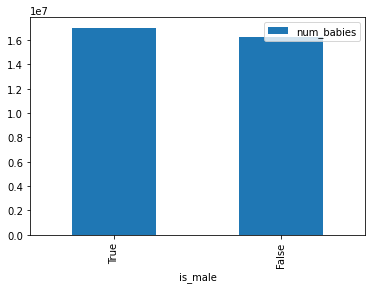

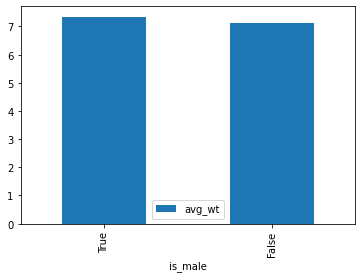

In [8]:
df = get_distinct_values('is_male')
df.plot(x='is_male', y='num_babies', kind='bar')
df.plot(x='is_male', y='avg_wt', kind='bar')

<AxesSubplot:xlabel='mother_age'>

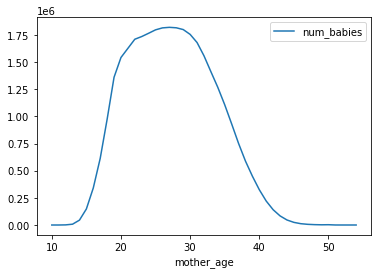

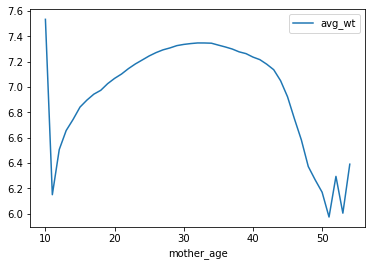

In [9]:
df = get_distinct_values('mother_age')
df = df.sort_values('mother_age')
df.plot(x='mother_age', y='num_babies')
df.plot(x='mother_age', y='avg_wt')

<AxesSubplot:xlabel='plurality'>

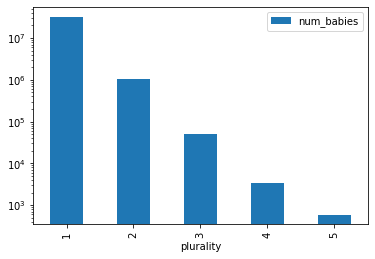

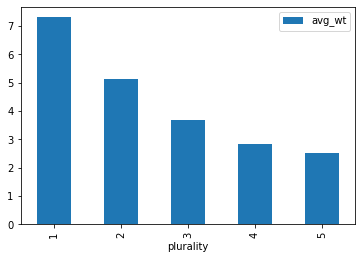

In [10]:
df = get_distinct_values('plurality')
df = df.sort_values('plurality')
df.plot(x='plurality', y='num_babies', logy=True, kind='bar')
df.plot(x='plurality', y='avg_wt', kind='bar')

<AxesSubplot:xlabel='gestation_weeks'>

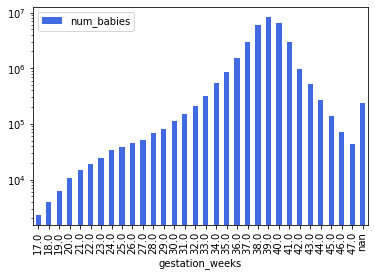

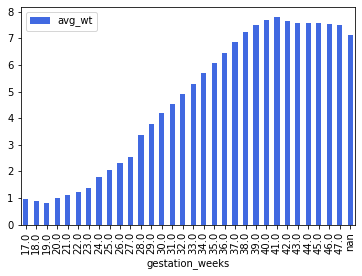

In [11]:
df = get_distinct_values('gestation_weeks')
df = df.sort_values('gestation_weeks')
df.plot(x='gestation_weeks', y='num_babies', logy=True, kind='bar', color='royalblue')
df.plot(x='gestation_weeks', y='avg_wt', kind='bar', color='royalblue')

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.

In the rest of this notebook, we will use machine learning to combine all of these factors to come up with a prediction of a baby's weight.

## Creating a ML dataset using Dataflow
I'm going to use Cloud Dataflow to read in the BigQuery data, do some preprocessing, and write it out as CSV files.

Instead of using Beam/Dataflow, I had three other options:

1. Use Cloud Dataprep to visually author a Dataflow pipeline. Cloud Dataprep also allows me to explore the data, so we could have avoided much of the handcoding of Python/Seaborn calls above as well!
2. Read from BigQuery directly using TensorFlow.
3. Use the BigQuery console (http://bigquery.cloud.google.com) to run a Query and save the result as a CSV file. For larger datasets, you may have to select the option to "allow large results" and save the result into a CSV file on Google Cloud Storage.

However, in this case, I want to do some preprocessing. I want to modify the data such that we can simulate what is known if no ultrasound has been performed. If I didn't need preprocessing, I could have used the web console. Also, I prefer to script it out rather than run queries on the user interface. Therefore, I am using Cloud Dataflow for the preprocessing.

In [12]:
import apache_beam as beam
import datetime

def to_csv(rowdict):
    # pull columns from BQ and create a line
    import hashlib
    import copy
    CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')
    
    # create synthetic data where we assume that no ultrasound has been performed
    # and so we don't know sex of the baby. Let's assume that we can tell the difference
    # between single and multiple, but that the errors rates in determining exact number
    # is difficult in the absence of an ultrasound.
    no_ultrasound = copy.deepcopy(rowdict)
    w_ultrasound = copy.deepcopy(rowdict)

    no_ultrasound['is_male'] = 'Unknown'
    if rowdict['plurality'] > 1:
        no_ultrasound['plurality'] = 'Multiple(2+)'
    else:
        no_ultrasound['plurality'] = 'Single(1)'
      
    # Change the plurality column to strings
    w_ultrasound['plurality'] = \
        ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)'][rowdict['plurality']-1]
    
    # Write out two rows for each input row, one with ultrasound and one without
    for result in [no_ultrasound, w_ultrasound]:
        data = ','.join([str(result[k]) if k in result else 'None' for k in CSV_COLUMNS])
        key = hashlib.sha224(data.encode('utf-8')).hexdigest()  # hash the columns to form a key
        yield str('{},{}'.format(data, key))
  
def preprocess(in_test_mode):
    job_name = 'preprocess-babyweight-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')
    
    if in_test_mode:
        OUTPUT_DIR = './preproc'
    else:
        OUTPUT_DIR = 'gs://{0}/babyweight/preproc/'.format(BUCKET)
    
    options = {
        'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
        'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
        'job_name': job_name,
        'project': PROJECT,
        'teardown_policy': 'TEARDOWN_ALWAYS',
        'max_num_workers': 3,   # CHANGE THIS IF YOU HAVE MORE QUOTA
        'no_save_main_session': True
    }
    opts = beam.pipeline.PipelineOptions(flags=[], **options)
    if in_test_mode:
        RUNNER = 'DirectRunner'
    else:
        RUNNER = 'DataflowRunner'
    p = beam.Pipeline(RUNNER, options=opts)
    query = """
SELECT
  weight_pounds,
  is_male,
  mother_age,
  plurality,
  gestation_weeks,
  FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING))) AS hashmonth
FROM
  publicdata.samples.natality
WHERE year > 2000
AND weight_pounds > 0
AND mother_age > 0
AND plurality > 0
AND gestation_weeks > 0
AND month > 0
    """
  
    if in_test_mode:
        query = query + ' LIMIT 100' 
  
    for step in ['train', 'eval']:
        if step == 'train':
            selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) < 3'.format(query)
        else:
            selquery = 'SELECT * FROM ({}) WHERE ABS(MOD(hashmonth, 4)) = 3'.format(query)

        (p 
         | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query=selquery, use_standard_sql=True))
         | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
         | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
        )
 
    job = p.run()
  
preprocess(in_test_mode=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:86: BeamDeprecationWarning: BigQuerySource is deprecated since 2.25.0. Use ReadFromBigQuery instead.


/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:1971: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


Note that after you launch this, the actual processing is happening on the Cloud. Go to the GCP web console to the Dataflow section and monitor the running job. You'll see a job that's running. It took about **30 minutes** for me.

Once the job has completed, run the cell below to check the location of the processed files.

In [13]:
%%bash
gsutil ls gs://${BUCKET}/babyweight/preproc/*-00000*

gs://babyweight-keras-ml/babyweight/preproc/eval.csv-00000-of-00008
gs://babyweight-keras-ml/babyweight/preproc/train.csv-00000-of-00009


# Part 2: Developing a Machine Learning Model using TensorFlow and Cloud ML Engine

## Creating a TensorFlow model using the Estimator API

First, write an read_dataset to create a generator object that reads the data.

In [14]:
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [15]:
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
SELECT_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks'.split(',')
LABEL_COLUMN = 'weight_pounds'

def read_dataset(prefix, pattern, batch_size=512, eval=False):
    # use prefix to create filename
    filename = 'gs://{}/babyweight/preproc/{}*{}*'.format(BUCKET, prefix, pattern)
    if eval:
        dataset = tf.data.experimental.make_csv_dataset(
            filename, header=False, batch_size=batch_size,
            shuffle=False, num_epochs=1,
            column_names=CSV_COLUMNS, label_name=LABEL_COLUMN,
            select_columns=SELECT_COLUMNS
        )
    else:
        dataset = tf.data.experimental.make_csv_dataset(
            filename, header=False, batch_size=batch_size,
            shuffle=True, num_epochs=None,
            column_names=CSV_COLUMNS, label_name=LABEL_COLUMN,
            select_columns=SELECT_COLUMNS
        )
    return dataset    

Next, define the feature columns.

In [16]:
def get_wide_deep():
    # defin model inputs
    inputs = {}
    inputs['is_male'] = layers.Input(shape=(), name='is_male', dtype='string')
    inputs['plurality'] = layers.Input(shape=(), name='plurality', dtype='string')
    inputs['mother_age'] = layers.Input(shape=(), name='mother_age', dtype='float32')
    inputs['gestation_weeks'] = layers.Input(shape=(), name='gestation_weeks', dtype='float32')
    
    # define column types
    is_male = tf.feature_column.categorical_column_with_vocabulary_list(
        'is_male', ['True', 'False', 'Unknown'])
    plurality = tf.feature_column.categorical_column_with_vocabulary_list(
        'plurality', ['Single(1)', 'Twins(2)', 'Triplets(3)', 'Quadruplets(4)', 'Quintuplets(5)', 'Multiple(2+)'])    
    mother_age = tf.feature_column.numeric_column('mother_age')
    gestation_weeks = tf.feature_column.numeric_column('gestation_weeks')

    # discretize
    age_buckets = tf.feature_column.bucketized_column(
        mother_age, boundaries=np.arange(15, 45, 1).tolist())
    gestation_buckets = tf.feature_column.bucketized_column(
        gestation_weeks, boundaries=np.arange(17, 47, 1).tolist())

    # sparse columns are wide 
    wide = [tf.feature_column.indicator_column(is_male),
            tf.feature_column.indicator_column(plurality),
            age_buckets,
            gestation_buckets]
    
    # feature cross all the wide columns and embed into a lower dimension
    crossed = tf.feature_column.crossed_column(
        [is_male, plurality, age_buckets, gestation_buckets], hash_bucket_size=20000)
    embed = tf.feature_column.embedding_column(crossed, 3)
    
    # continuous columns are deep
    deep = [mother_age,
            gestation_weeks,
            embed]

    return wide, deep, inputs

Define the wide and deep model using the Keras API.

In [17]:
def create_keras_model():
    wide, deep, inputs = get_wide_deep()
    feature_layer_wide = layers.DenseFeatures(wide, name='wide_features')
    feature_layer_deep = layers.DenseFeatures(deep, name='deep_features')

    wide_model = feature_layer_wide(inputs)
    
    deep_model = layers.Dense(64, activation='relu', name='DNN_layer1')(feature_layer_deep(inputs))
    deep_model = layers.Dense(32, activation='relu', name='DNN_layer2')(deep_model)

    wide_deep_model = layers.Dense(1, name='weight')(layers.concatenate([wide_model, deep_model]))
    model = models.Model(inputs=inputs, outputs=wide_deep_model)

    # Compile Keras model
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0001))
    return model

Finally, train the model locally on the notebook environment.

In [18]:
keras_model = create_keras_model()

PATTERN = "00000-of-"  # process only one of the shards, for testing purposes
BATCH_SIZE = 512
NUM_TRAIN_EXAMPLES = 1000000
NUM_EVAL_EXAMPLES = 10000
NUM_EVALS = 10

training_dataset = read_dataset('train', PATTERN, BATCH_SIZE)
validation_dataset = read_dataset('eval', PATTERN, BATCH_SIZE).take(NUM_EVAL_EXAMPLES//BATCH_SIZE)

history = keras_model.fit(
    training_dataset,
    steps_per_epoch=NUM_TRAIN_EXAMPLES//(BATCH_SIZE * NUM_EVALS),
    epochs=NUM_EVALS,
    validation_data=validation_dataset
)

Epoch 1/10
195/195 [==============================] - 3s 14ms/step - loss: 7.1371 - val_loss: 1.6387
Epoch 2/10
195/195 [==============================] - 3s 15ms/step - loss: 1.4740 - val_loss: 1.4089
Epoch 3/10
195/195 [==============================] - 2s 12ms/step - loss: 1.3739 - val_loss: 1.4015
Epoch 4/10
195/195 [==============================] - 3s 15ms/step - loss: 1.1895 - val_loss: 1.5342
Epoch 5/10
195/195 [==============================] - 3s 13ms/step - loss: 1.1764 - val_loss: 2.1909
Epoch 6/10
195/195 [==============================] - 3s 14ms/step - loss: 1.1800 - val_loss: 2.8775
Epoch 7/10
195/195 [==============================] - 2s 10ms/step - loss: 1.1675 - val_loss: 4.0380
Epoch 8/10
195/195 [==============================] - 3s 14ms/step - loss: 1.1416 - val_loss: 3.9998
Epoch 9/10
195/195 [==============================] - 2s 10ms/step - loss: 1.1240 - val_loss: 4.7713
Epoch 10/10
195/195 [==============================] - 2s 8ms/step - loss: 1.1160 - val_los

In [19]:
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
______________________________________________________________________________________________

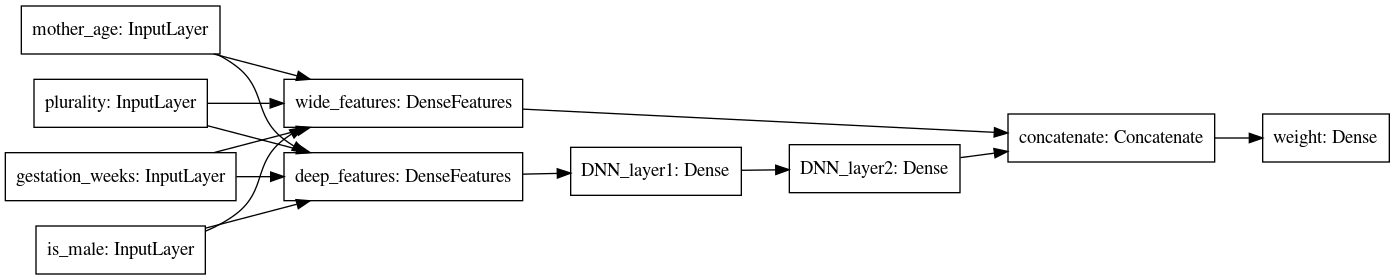

In [20]:
tf.keras.utils.plot_model(
    model=keras_model, to_file="dnn_model.png", show_shapes=False, rankdir="LR")

You can export the trainined model in the saved_model format with the following command.

In [21]:
import datetime
ts = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
export_path = "gs://{}/babyweight/trained_model/export/{}".format(BUCKET, ts)
keras_model.save(export_path, save_format="tf")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


To make predictions locally with the trained model, you need a preprocess function. As shown in the later section, when you deploy it to the AI Platform using the saved_model, the preprocessing is automatically added.

In [51]:
def preprocess(req):
    data = {}
    for instance in req['instances']:
        for key, value in instance.items():
            if not key in data.keys():
                data[key] = []
            data[key].append((value,))
    return tf.data.Dataset.from_tensor_slices(data)

In [52]:
request_data = {'instances':
  [
    {
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
  ]
}

keras_model.predict(preprocess(request_data))

array([[5.602193],
       [6.725526]], dtype=float32)

Now that we have the TensorFlow code working on a subset of the data (in the code above, I was reading only the 00000-of-x file), we can package the TensorFlow code up as a Python module and train it on Cloud AI Platform.

In [28]:
%%bash
cd $NOTEBOOK_DIR
ls -l trainer

total 12
-rw-r--r-- 1 jupyter jupyter    0 Nov 23 06:08 __init__.py
-rw-r--r-- 1 jupyter jupyter 4342 Nov 23 06:08 model.py
-rw-r--r-- 1 jupyter jupyter 3860 Nov 23 06:08 task.py


After moving the code to a package, make sure it works standalone. (Note the --num-train-example and --num-eval-examples lines so that I am not trying to boil the ocean on my laptop). Even then, this takes about **a minute** in which you won't see any output...

In [30]:
%%bash
cd $NOTEBOOK_DIR
gcloud ai-platform local train \
 --package-path trainer \
 --module-name trainer.task \
 --job-dir local-training-output \
 -- \
 --bucket $BUCKET \
 --num-train-examples 10000 \
 --num-eval-examples 1000 \
 --num-evals 4 \
 --learning-rate 0.001

Epoch 1/4
19/19 [==============================] - 2s 83ms/step - loss: 9.2353 - val_loss: 5.2838
Epoch 2/4
19/19 [==============================] - 0s 22ms/step - loss: 2.1148 - val_loss: 2.1172
Epoch 3/4
19/19 [==============================] - 0s 23ms/step - loss: 1.3234 - val_loss: 2.0525
Epoch 4/4
19/19 [==============================] - 0s 21ms/step - loss: 1.1866 - val_loss: 2.3361
Model exported to: local-training-output/export/20201123064458


2020-11-23 06:44:58.444851: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2020-11-23 06:44:58.445042: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2020-11-23 06:44:58.445110: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-3-20201123-150230): /proc/driver/nvidia/version does not exist
2020-11-23 06:44:58.445498: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-11-23 06:44:58.454896: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200195000 Hz
2020-11-23 06:44:58.455422: I tensorflow/compile

Once the code works in standalone mode, you can run it on Cloud AI Platform. Because this is on the entire dataset, it will take a while. The training run took about **60 minutes** for me. You can monitor the job from the GCP console in the AI Platform section.

In [34]:
%%bash
JOB_NAME=babyweight_$(date -u +%y%m%d_%H%M%S)
JOB_DIR=gs://${BUCKET}/babyweight/trained_model

cd $NOTEBOOK_DIR
gcloud ai-platform jobs submit training $JOB_NAME \
  --job-dir $JOB_DIR \
  --package-path trainer/ \
  --module-name trainer.task \
  --region $REGION \
  --python-version 3.7 \
  --runtime-version 2.2 \
  --scale-tier basic-gpu \
  -- \
  --bucket $BUCKET \
  --num-train-examples 60000000 \
  --num-eval-examples 50000 \
  --num-evals 100 \
  --learning-rate 0.0001

jobId: babyweight_201123_075703
state: QUEUED


Job [babyweight_201123_075703] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe babyweight_201123_075703

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs babyweight_201123_075703


Training logs are stored in the following location of the GCS bucket.

In [35]:
%%bash
gsutil ls gs://${BUCKET}/babyweight/trained_model/tensorboard/ | tail -1

gs://babyweight-keras-ml/babyweight/trained_model/tensorboard/20201123080216/


You can launch the TensorBoard with the followind command on the Cloud Shell. Use the web preview with port 6006 to access it.

```
tensorboard --logdir [GCS path]
```

The following image is an example graph for MSE. The final MSE for the eval data is about 1.6, that is, RMSE=1.2lbs

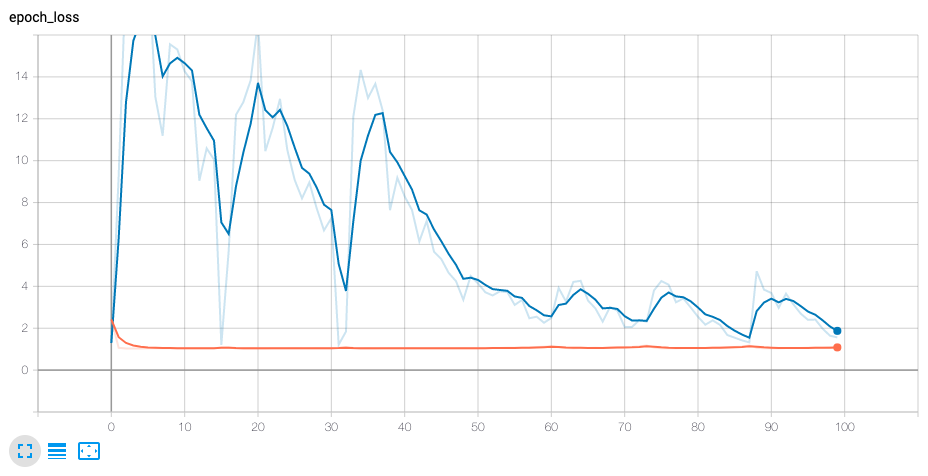

In [48]:
from IPython.display import Image
Image(filename='{}/tensorboard.png'.format(NOTEBOOK_DIR), width=600)

## Deploying the trained model

Deploying the trained model to act as a REST web service is a simple gcloud call.

In [50]:
%%bash
gsutil ls gs://${BUCKET}/babyweight/trained_model/export/ | tail -1

gs://babyweight-keras-ml/babyweight/trained_model/export/20201123080216/


In [51]:
%%bash
MODEL_NAME="babyweight"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/babyweight/trained_model/export/ | tail -1)
echo "Deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} \
  --origin ${MODEL_LOCATION} --runtime-version 2.2

Deploying babyweight v1 from gs://babyweight-keras-ml/babyweight/trained_model/export/20201123080216/ ... this will take a few minutes


Using endpoint [https://ml.googleapis.com/]
Created ml engine model [projects/babyweight-keras/models/babyweight].
Using endpoint [https://ml.googleapis.com/]
Creating version (this might take a few minutes)......
..................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Using the model to predict

Send a JSON request to the endpoint of the service to make it predict a baby's weight ... I am going to try out how well the model would have predicted the weights of our two kids and a couple of variations while we are at it ...

In [52]:
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials, cache_discovery=False)

request_data = {'instances':
  [
    {
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'babyweight', 'v1')
response = api.projects().predict(body=request_data, name=parent).execute()
print(json.dumps(response, sort_keys = True, indent = 4))

{
    "predictions": [
        {
            "weight": [
                7.9085187911987305
            ]
        },
        {
            "weight": [
                7.492921829223633
            ]
        },
        {
            "weight": [
                6.517521858215332
            ]
        },
        {
            "weight": [
                6.440060615539551
            ]
        }
    ]
}


When I ran this, the four predictions for each of the requests in request_data above are 7.9, 7.5, 6.5, and 6.4 pounds. Yours may be different.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License